# MLOps with TFX Pipeline

Author - [Hasan Rafiq](https://www.linkedin.com/in/sam04/)


## **TensorFlow Extended (TFX)** 
Is an end-to-end platform for deploying production ML pipelines

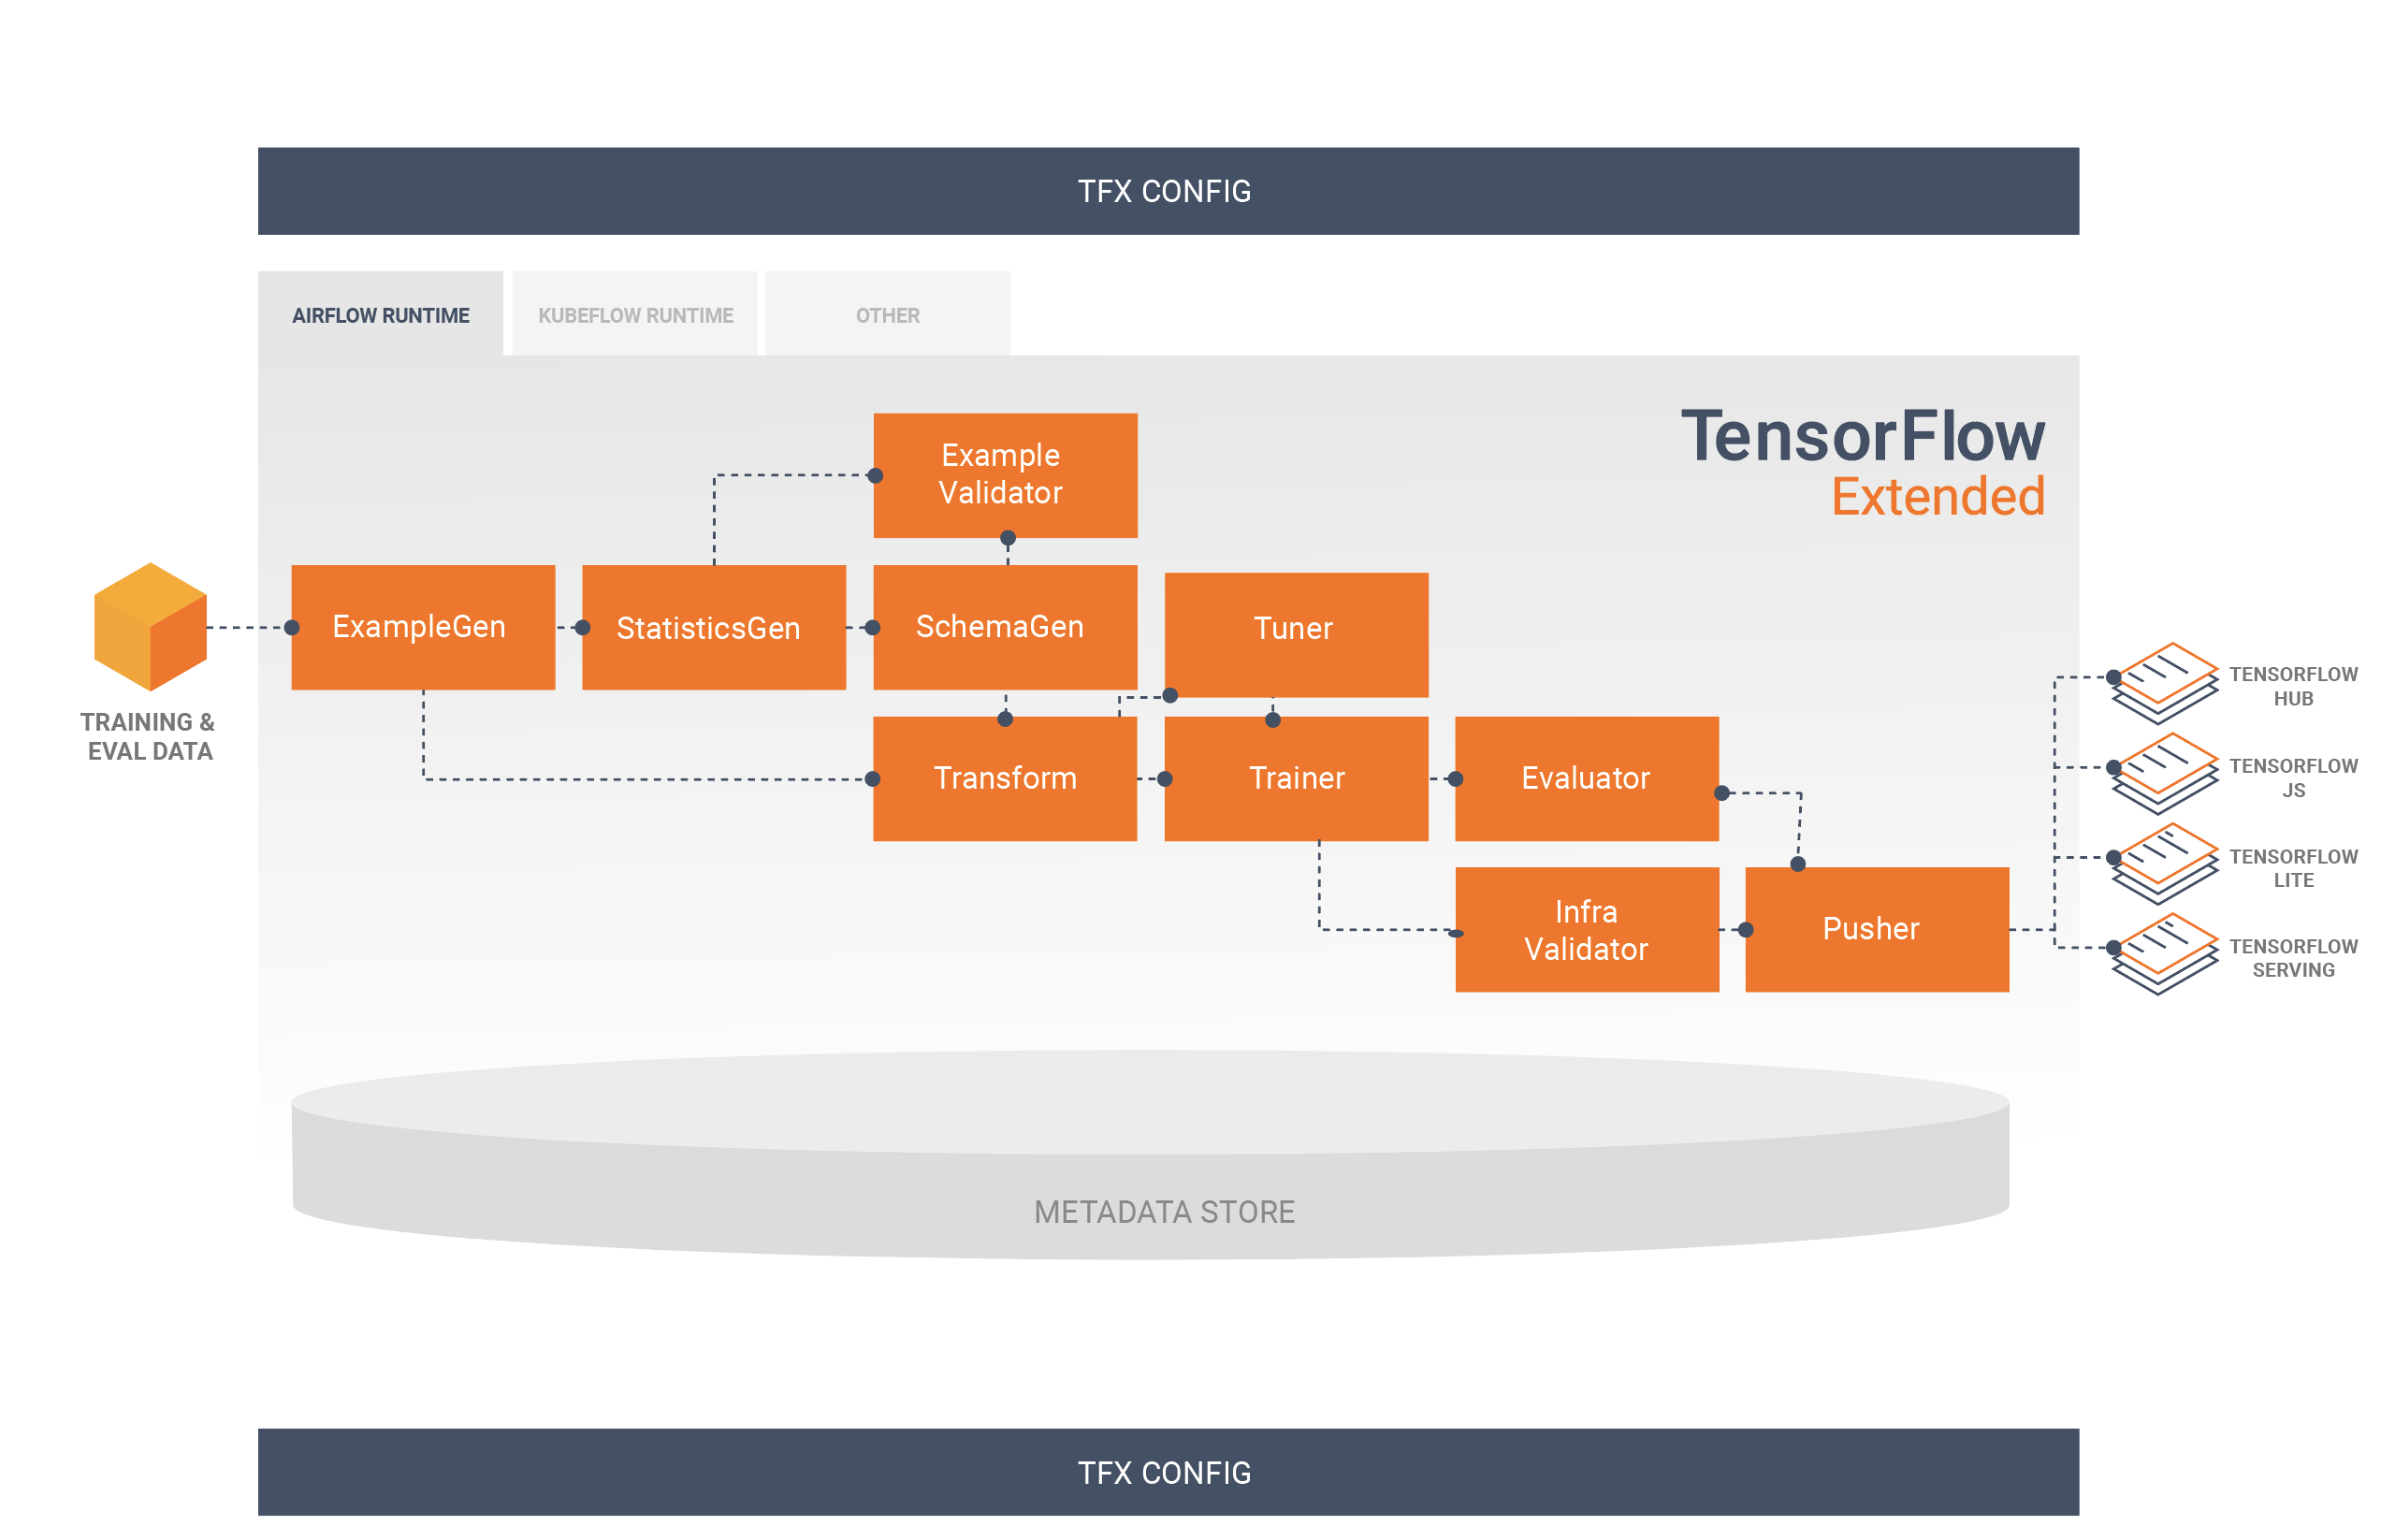

### **Enterprise ML is not about the best model:**
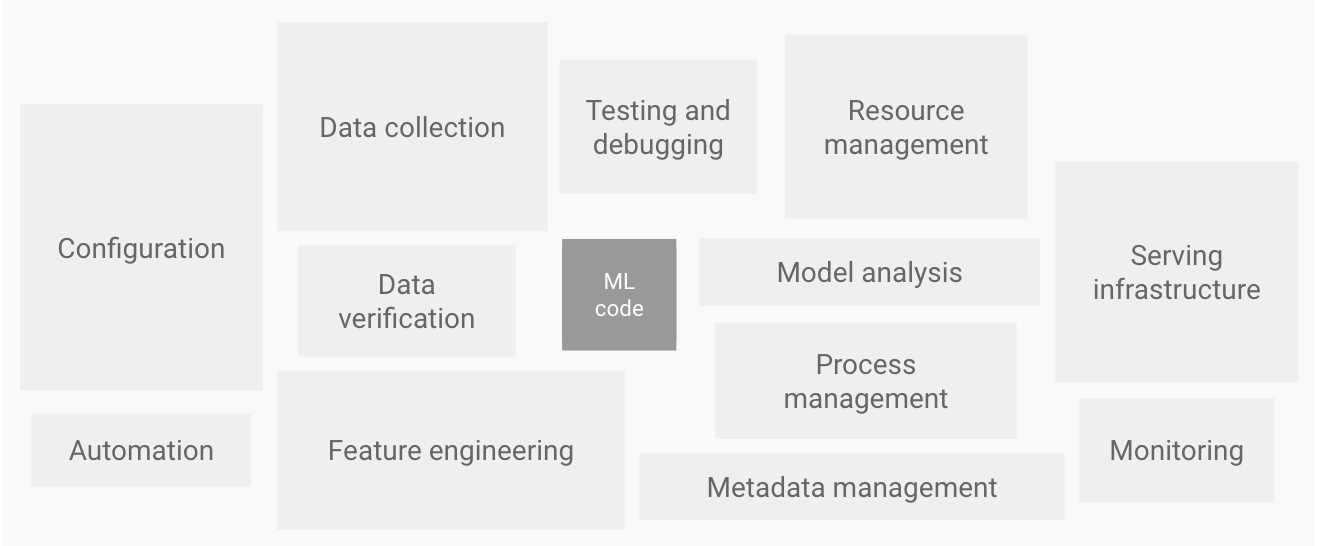

### **Corresponding TFX libraries per component**:

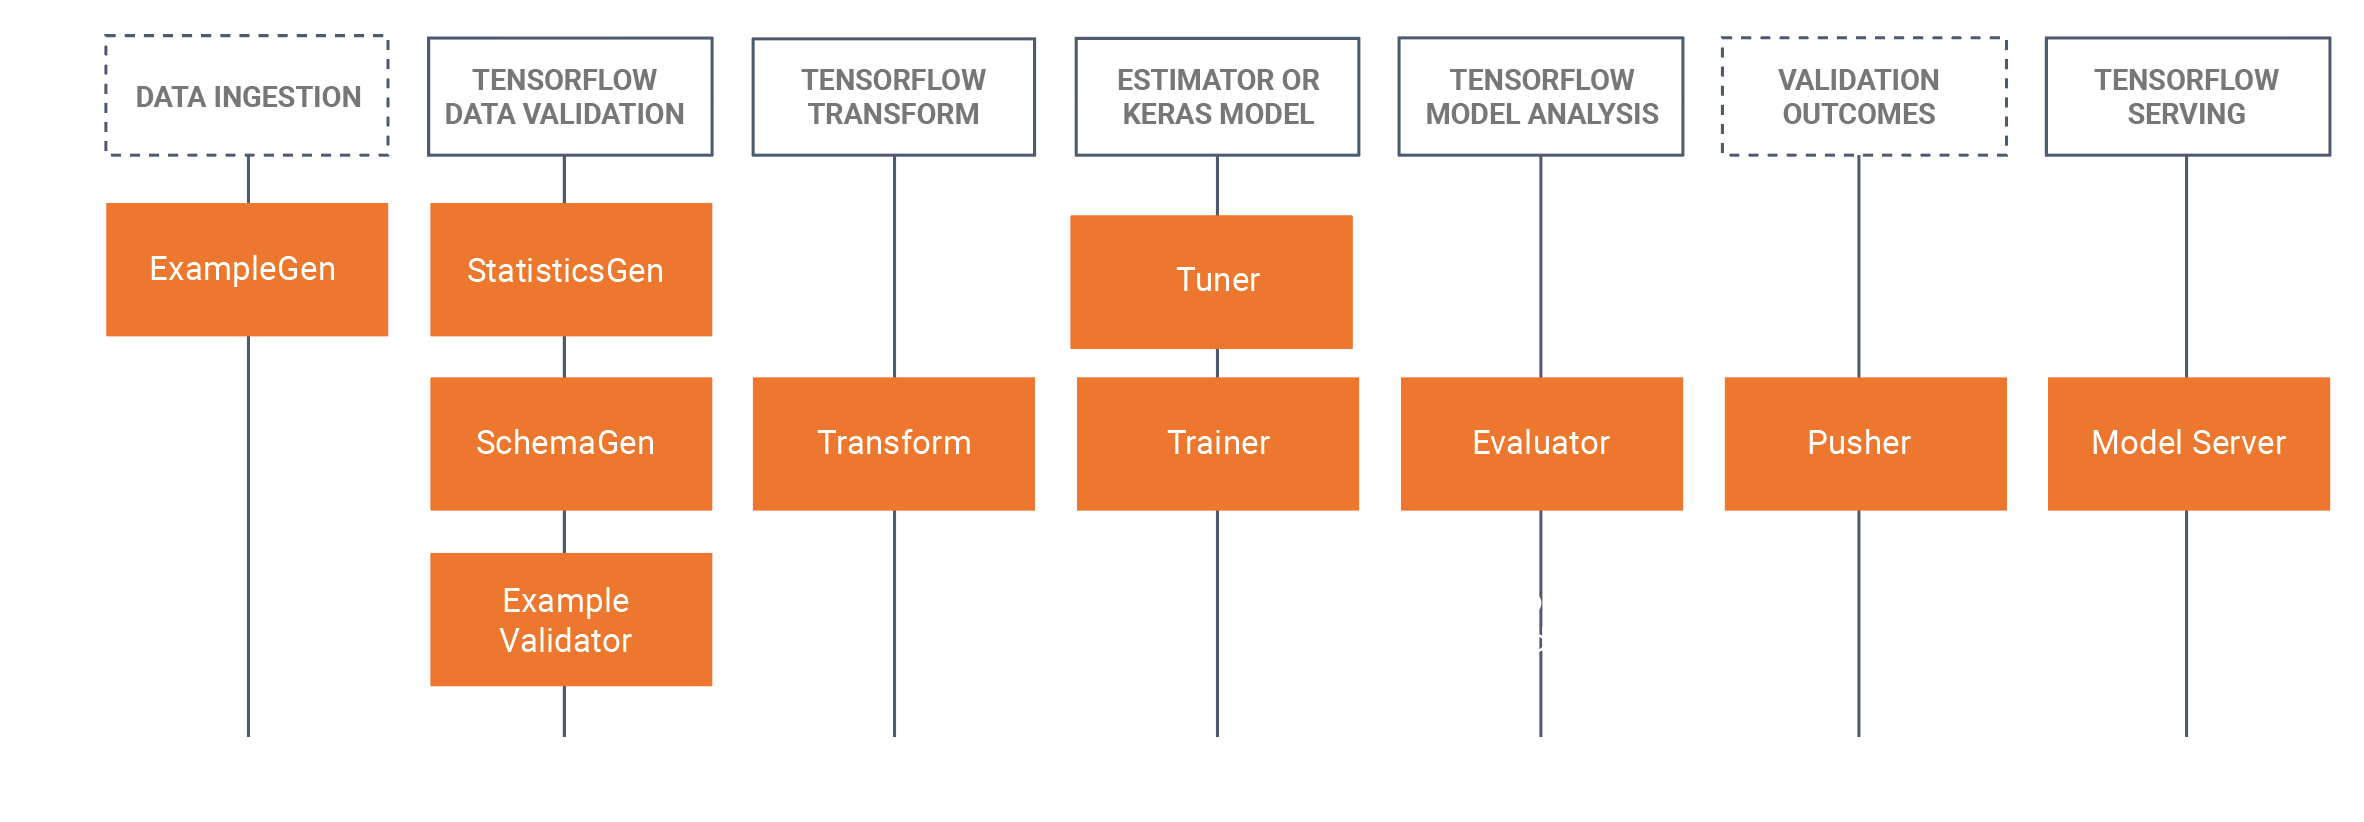

In [ ]:
!pip install tfx

In [ ]:
import os
import pprint
import numpy as np
import tempfile
import urllib

import absl
import pandas as pd
import tensorflow as tf
import tensorflow_model_analysis as tfma
tf.get_logger().propagate = False
pp = pprint.PrettyPrinter()

import tfx
from tfx.components import CsvExampleGen
from typing import Dict, List, Text
from tfx.components import Evaluator
from tfx.components import ExampleValidator
from tfx.components import Pusher
from tfx.components import ResolverNode
from tfx.components import SchemaGen
from tfx.components import StatisticsGen
from tfx.components import Trainer
from tfx.components import Transform
from tfx.components.base import executor_spec
from tfx.components.trainer.executor import GenericExecutor
from tfx.dsl.experimental import latest_blessed_model_resolver
from tfx.orchestration import metadata
from tfx.orchestration import pipeline
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from tfx.proto import pusher_pb2
from tfx.proto import trainer_pb2
from tfx.types import Channel
from tfx.types.standard_artifacts import Model
from tfx.types.standard_artifacts import ModelBlessing
from tfx.utils.dsl_utils import external_input


%load_ext tfx.orchestration.experimental.interactive.notebook_extensions.skip

Let's check the library versions.

In [ ]:
print('TensorFlow version: {}'.format(tf.__version__))
print('TFX version: {}'.format(tfx.__version__))

TensorFlow version: 2.4.1
TFX version: 0.28.0


In [ ]:
!rm -rf data.*
!rm -rf *trainer.py
!sudo rm -r /content/tfx

rm: cannot remove '/content/tfx': No such file or directory


In [ ]:
! cd /content/
! mkdir /content/tfx/
! mkdir /content/tfx/pipelines
! mkdir /content/tfx/metadata
! mkdir /content/tfx/logs
! mkdir /content/tfx/data
! mkdir /content/tfx/serving_model

### Download example data
We download the example dataset for use in our TFX pipeline.

The dataset we're using is the [Taxi Trips dataset](https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew) released by the City of Chicago. The columns in this dataset are:

<table>
<tr><td>pickup_community_area</td><td>fare</td><td>trip_start_month</td></tr>
<tr><td>trip_start_hour</td><td>trip_start_day</td><td>trip_start_timestamp</td></tr>
<tr><td>pickup_latitude</td><td>pickup_longitude</td><td>dropoff_latitude</td></tr>
<tr><td>dropoff_longitude</td><td>trip_miles</td><td>pickup_census_tract</td></tr>
<tr><td>dropoff_census_tract</td><td>payment_type</td><td>company</td></tr>
<tr><td>trip_seconds</td><td>dropoff_community_area</td><td>tips</td></tr>
</table>

With this dataset, we will build a model that predicts the `fare` of a trip.

In [ ]:
!wget https://raw.githubusercontent.com/tensorflow/tfx/master/tfx/examples/chicago_taxi_pipeline/data/simple/data.csv

--2021-03-27 14:45:42--  https://raw.githubusercontent.com/tensorflow/tfx/master/tfx/examples/chicago_taxi_pipeline/data/simple/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1922812 (1.8M) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]   1.83M  --.-KB/s    in 0.08s   

2021-03-27 14:45:43 (23.8 MB/s) - ‘data.csv’ saved [1922812/1922812]



In [ ]:
df = pd.read_csv('/content/data.csv')

##Drop useless columns
df = df.drop(['trip_start_timestamp','trip_miles','pickup_census_tract',
              'dropoff_census_tract','trip_seconds','payment_type','tips', 
              'company','dropoff_community_area','pickup_community_area'], axis=1)

#Drop NA rows
df = df.dropna()

##Keep a test set for final testing( TFX internally splits train and validation data )
np.random.seed(seed=2)
msk = np.random.rand(len(df)) < 0.9
traindf = df[msk]
evaldf = df[~msk]

print(len(traindf))
print(len(evaldf))

traindf.to_csv("/content/tfx/data/data_trans.csv", index=False, header=True)
evaldf.to_csv("eval.csv", index=False, header=False)

13077
1442


Take a quick look at the CSV file.

In [ ]:
!head {_data_filepath}

head: cannot open '{_data_filepath}' for reading: No such file or directory


### Set up pipeline paths

In [ ]:
##Define all constant
_tfx_root = os.path.join(os.getcwd(), 'tfx');        # Create location ~/tfx
_pipeline_root = os.path.join(_tfx_root, 'pipelines');      # Join ~/tfx/pipelines/
_metadata_db_root = os.path.join(_tfx_root, 'metadata.db');    # Join ~/tfx/metadata.db
_log_root = os.path.join(_tfx_root, 'logs');
_model_root = os.path.join(_tfx_root, 'model');
_data_root = os.path.join(_tfx_root, 'data');
_serving_model_dir = os.path.join(_tfx_root, 'serving_model')
_data_filepath = os.path.join(_data_root, "data_trans.csv")

_input_fn_module_file = 'inputfn_trainer.py'
_constants_module_file = 'constants_trainer.py'
_model_trainer_module_file = 'model_trainer.py'

### Create the InteractiveContext
Last, we create an InteractiveContext, which will allow us to run TFX components interactively in this notebook.

In [ ]:
# Here, we create an InteractiveContext using default parameters. This will
# use a temporary directory with an ephemeral ML Metadata database instance.
# To use your own pipeline root or database, the optional properties
# `pipeline_root` and `metadata_connection_config` may be passed to
# InteractiveContext. Calls to InteractiveContext are no-ops outside of the
# notebook.
context = InteractiveContext(pipeline_root=_tfx_root)

## Run TFX components interactively
In the cells that follow, we create TFX components one-by-one, run each of them, and visualize their output artifacts.

### ExampleGen

The `ExampleGen` component is usually at the start of a TFX pipeline. It will:

1.   **Split** data( placed in _data_root ) into training and evaluation sets (by default, 2/3 training + 1/3 eval)
2.   Convert data into the `tf.Example` format
3.   **Copy splits** into the `_tfx_root` directory for other components to access

`ExampleGen` takes as input the path to your data source. In our case, this is the `_data_root` path that contains the downloaded CSV.

Note: In this notebook, we can instantiate components one-by-one and run them with `InteractiveContext.run()`. By contrast, in a production setting, we would specify all the components upfront in a `Pipeline` to pass to the orchestrator (see the [Building a TFX Pipeline Guide](../tfx/guide/build_tfx_pipeline)).

In [ ]:
example_gen = CsvExampleGen(input=external_input(_data_root))
context.run(example_gen)

Instructions for updating:
external_input is deprecated, directly pass the uri to ExampleGen.


ExecutionResult(
    component_id: CsvExampleGen
    execution_id: 1
    outputs:
        examples: Channel(
            type_name: Examples
            artifacts: [Artifact(artifact: id: 1
        type_id: 5
        uri: "/content/tfx/CsvExampleGen/examples/1"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "input_fingerprint"
          value {
            string_value: "split:single_split,num_files:1,total_bytes:907007,xor_checksum:1616856396,sum_checksum:1616856396"
          }
        }
        custom_properties {
          key: "payload_format"
          value {
            string_value: "FORMAT_TF_EXAMPLE"
          }
        }
        custom_properties {
          key: "span"
          value {
            string_value: "0"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        state: LIVE
        , artifact_type: id: 5
        name: "Examples"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        properties {
          key: "version"
          value: INT
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

Let's examine the output artifacts of `ExampleGen`. This component produces two artifacts, training examples and evaluation examples:

In [ ]:
artifact = example_gen.outputs['examples'].get()[0]
print(artifact.split_names, artifact.uri)

["train", "eval"] /content/tfx/CsvExampleGen/examples/1


We can also take a look at the first three training examples:

In [ ]:
# Get the URI of the output artifact representing the training examples, which is a directory
train_uri = os.path.join(example_gen.outputs['examples'].get()[0].uri, 'train')

# Get the list of files in this directory (all compressed TFRecord files)
tfrecord_filenames = [os.path.join(train_uri, name)
                      for name in os.listdir(train_uri)]

# Create a `TFRecordDataset` to read these files
dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")

# Iterate over the first 3 records and decode them.
for tfrecord in dataset.take(3):
  serialized_example = tfrecord.numpy()
  example = tf.train.Example()
  example.ParseFromString(serialized_example)
  pp.pprint(example)

features {
  feature {
    key: "dropoff_latitude"
    value {
      float_list {
        value: 41.92045211791992
      }
    }
  }
  feature {
    key: "dropoff_longitude"
    value {
      float_list {
        value: -87.6799545288086
      }
    }
  }
  feature {
    key: "fare"
    value {
      float_list {
        value: 3.8499999046325684
      }
    }
  }
  feature {
    key: "pickup_latitude"
    value {
      float_list {
        value: 41.8996696472168
      }
    }
  }
  feature {
    key: "pickup_longitude"
    value {
      float_list {
        value: -87.66983795166016
      }
    }
  }
  feature {
    key: "trip_start_day"
    value {
      int64_list {
        value: 6
      }
    }
  }
  feature {
    key: "trip_start_hour"
    value {
      int64_list {
        value: 15
      }
    }
  }
  feature {
    key: "trip_start_month"
    value {
      int64_list {
        value: 3
      }
    }
  }
}

features {
  feature {
    key: "dropoff_latitude"
    value {
      fl

Now that `ExampleGen` has finished ingesting the data, the next step is data analysis.

### StatisticsGen
The `StatisticsGen` component **computes statistics** over your dataset for data analysis, as well as for use in downstream components. It uses the [TensorFlow Data Validation](https://www.tensorflow.org/tfx/data_validation/get_started) library.

`StatisticsGen` takes as input the dataset we just ingested using `ExampleGen`.

In [ ]:
statistics_gen = StatisticsGen(
    examples=example_gen.outputs['examples'])
context.run(statistics_gen)

ExecutionResult(
    component_id: StatisticsGen
    execution_id: 2
    outputs:
        statistics: Channel(
            type_name: ExampleStatistics
            artifacts: [Artifact(artifact: id: 2
        type_id: 7
        uri: "/content/tfx/StatisticsGen/statistics/2"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "name"
          value {
            string_value: "statistics"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "StatisticsGen"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        state: LIVE
        , artifact_type: id: 7
        name: "ExampleStatistics"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

After `StatisticsGen` finishes running, we can visualize the outputted statistics - **TFDV**. Try playing with the different plots!

In [ ]:
context.show(statistics_gen.outputs['statistics'])

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


### SchemaGen

The `SchemaGen` component generates a schema based on your data statistics( outputs of StatisticsGen ). (A schema defines the expected bounds, types, and properties of the features in your dataset.) It also uses the [TensorFlow Data Validation](https://www.tensorflow.org/tfx/data_validation/get_started) library.

Note: The generated schema is best-effort and only tries to infer basic properties of the data. It is expected that you review and modify it as needed.

`SchemaGen` will take as input the statistics that we generated with `StatisticsGen`, looking at the training split by default.

In [ ]:
schema_gen = SchemaGen(
    statistics=statistics_gen.outputs['statistics'],
    infer_feature_shape=False)
context.run(schema_gen)

ExecutionResult(
    component_id: SchemaGen
    execution_id: 3
    outputs:
        schema: Channel(
            type_name: Schema
            artifacts: [Artifact(artifact: id: 3
        type_id: 9
        uri: "/content/tfx/SchemaGen/schema/3"
        custom_properties {
          key: "name"
          value {
            string_value: "schema"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "SchemaGen"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        state: LIVE
        , artifact_type: id: 9
        name: "Schema"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

After `SchemaGen` finishes running, we can visualize the generated schema as a table.

In [ ]:
context.show(schema_gen.outputs['schema'])

,Type,Presence,Valency,Domain
Feature name,,,,
'dropoff_latitude',FLOAT,required,single,-
'dropoff_longitude',FLOAT,required,single,-
'fare',FLOAT,required,single,-
'pickup_latitude',FLOAT,required,single,-
'pickup_longitude',FLOAT,required,single,-
'trip_start_day',INT,required,single,-
'trip_start_hour',INT,required,single,-
'trip_start_month',INT,required,single,-


Each feature in your dataset shows up as a row in the schema table, alongside its properties. The schema also captures all the values that a categorical feature takes on, denoted as its domain.

To learn more about schemas, see [the SchemaGen documentation](https://www.tensorflow.org/tfx/guide/schemagen).

### ExampleValidator
The `ExampleValidator` component detects anomalies in your data, based on the expectations defined by the schema. It also uses the [TensorFlow Data Validation](https://www.tensorflow.org/tfx/data_validation/get_started) library.

`ExampleValidator` will take as input the statistics from `StatisticsGen`, and the schema from `SchemaGen`.

In [ ]:
example_validator = ExampleValidator(
    statistics=statistics_gen.outputs['statistics'],
    schema=schema_gen.outputs['schema'])
context.run(example_validator)

ExecutionResult(
    component_id: ExampleValidator
    execution_id: 4
    outputs:
        anomalies: Channel(
            type_name: ExampleAnomalies
            artifacts: [Artifact(artifact: id: 4
        type_id: 11
        uri: "/content/tfx/ExampleValidator/anomalies/4"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "name"
          value {
            string_value: "anomalies"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "ExampleValidator"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        state: LIVE
        , artifact_type: id: 11
        name: "ExampleAnomalies"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

After `ExampleValidator` finishes running, we can visualize the anomalies as a table.

In [ ]:
context.show(example_validator.outputs['anomalies'])

/usr/local/lib/python3.7/dist-packages/tensorflow_data_validation/utils/display_util.py:188: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


In the anomalies table, we can see that there are no anomalies. This is what we'd expect, since this the first dataset that we've analyzed and the schema is tailored to it. You should review this schema -- anything unexpected means an anomaly in the data. Once reviewed, the schema can be used to guard future data, and anomalies produced here can be used to debug model performance, understand how your data evolves over time, and identify data errors.

In [ ]:
# Get the URI of the output artifact representing the transformed examples, which is a directory
train_uri = os.path.join(example_gen.outputs['examples'].get()[0].uri, 'train')

# Get the list of files in this directory (all compressed TFRecord files)
tfrecord_filenames = [os.path.join(train_uri, name)
                      for name in os.listdir(train_uri)]

# Create a `TFRecordDataset` to read these files
dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")

# Iterate over the first 1 records and decode them.
for tfrecord in dataset.take(1):
  serialized_example = tfrecord.numpy()
  example = tf.train.Example()
  example.ParseFromString(serialized_example)
  pp.pprint(example)

features {
  feature {
    key: "dropoff_latitude"
    value {
      float_list {
        value: 41.92045211791992
      }
    }
  }
  feature {
    key: "dropoff_longitude"
    value {
      float_list {
        value: -87.6799545288086
      }
    }
  }
  feature {
    key: "fare"
    value {
      float_list {
        value: 3.8499999046325684
      }
    }
  }
  feature {
    key: "pickup_latitude"
    value {
      float_list {
        value: 41.8996696472168
      }
    }
  }
  feature {
    key: "pickup_longitude"
    value {
      float_list {
        value: -87.66983795166016
      }
    }
  }
  feature {
    key: "trip_start_day"
    value {
      int64_list {
        value: 6
      }
    }
  }
  feature {
    key: "trip_start_hour"
    value {
      int64_list {
        value: 15
      }
    }
  }
  feature {
    key: "trip_start_month"
    value {
      int64_list {
        value: 3
      }
    }
  }
}



### Transform
We can use TFT here but, specifically I am using other options like constants calculated via Pandas / Numpy etc. These all will be stored on a **constants_trainer.py** file and then used in trainer.

In [ ]:
bins_lat = pd.qcut(list(df['dropoff_latitude'].values) + list(df['pickup_latitude'].values), q=20, duplicates='drop', retbins=True)[1]
bins_lon = pd.qcut(list(df['dropoff_longitude'].values) + list(df['pickup_longitude'].values), q=20, duplicates='drop', retbins=True)[1]

In [ ]:
code = '''
bins_lat = {bins_lat}
bins_lon = {bins_lon}
'''

code = code.replace('{bins_lat}', str(list(bins_lat)))
code = code.replace('{bins_lon}', str(list(bins_lon)))

with open(_constants_module_file, 'w') as writefile:
    writefile.write(code)

After the `Transform` component has transformed your data into features, and the next step is to train a model.

### Trainer
The `Trainer` component will train a model that you define in TensorFlow. Default Trainer support Estimator API, to use Keras API, you need to specify [Generic Trainer](https://github.com/tensorflow/community/blob/master/rfcs/20200117-tfx-generic-trainer.md) by setup `custom_executor_spec=executor_spec.ExecutorClassSpec(GenericExecutor)` in Trainer's contructor.

`Trainer` takes as input the schema from `SchemaGen`, the transformed data and graph from `Transform`, training parameters, as well as a module that contains user-defined model code.

Will generate two files: 
- **inputfn_trainer.py** *Data-Feeder to model
- **model_trainer.py** *Trainer module

In [ ]:
%%writefile {_input_fn_module_file}

import os
import tensorflow as tf

###############################
##Feature engineering functions
def feature_engg_features(features):
  #Add new features
  features['distance'] = ((features['pickup_latitude'] - features['dropoff_latitude'])**2 +  (features['pickup_longitude'] - features['dropoff_longitude'])**2)**0.5
  features['trip_start_month'] = tf.strings.as_string(features['trip_start_month'])
  features['trip_start_hour'] = tf.strings.as_string(features['trip_start_hour'])
  features['trip_start_day'] = tf.strings.as_string(features['trip_start_day'])

  return(features)

#To be called from TF
def feature_engg(features, label):
  #Add new features
  features = feature_engg_features(features)

  return(features, label)

def make_input_fn(dir_uri, mode, vnum_epochs = None, batch_size = 512):
    def decode_tfr(serialized_example):
      # 1. define a parser
      features = tf.io.parse_example(
        serialized_example,
        # Defaults are not specified since both keys are required.
        features={
            'dropoff_latitude': tf.io.FixedLenFeature([], tf.float32),
            'dropoff_longitude': tf.io.FixedLenFeature([], tf.float32),
            'fare': tf.io.FixedLenFeature([], tf.float32),
            'pickup_latitude': tf.io.FixedLenFeature([], tf.float32, default_value = 0.0),
            'pickup_longitude': tf.io.FixedLenFeature([], tf.float32, default_value = 0.0),
            'trip_start_day': tf.io.FixedLenFeature([], tf.int64),
            'trip_start_hour': tf.io.FixedLenFeature([], tf.int64),
            'trip_start_month': tf.io.FixedLenFeature([], tf.int64)
        })

      return features, features['fare']

    def _input_fn(v_test=False):
      # Get the list of files in this directory (all compressed TFRecord files)
      tfrecord_filenames = tf.io.gfile.glob(dir_uri)

      # Create a `TFRecordDataset` to read these files
      dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")

      if mode == tf.estimator.ModeKeys.TRAIN:
        num_epochs = vnum_epochs # indefinitely
      else:
        num_epochs = 1 # end-of-input after this

      dataset = dataset.batch(batch_size)
      dataset = dataset.prefetch(buffer_size = batch_size)

      #Convert TFRecord data to dict
      dataset = dataset.map(decode_tfr)

      #Feature engineering
      dataset = dataset.map(feature_engg)

      if mode == tf.estimator.ModeKeys.TRAIN:
          num_epochs = vnum_epochs # indefinitely
          dataset = dataset.shuffle(buffer_size = batch_size)
      else:
          num_epochs = 1 # end-of-input after this

      dataset = dataset.repeat(num_epochs)       
      
      #Begins - Uncomment for testing only -----------------------------------------------------<
      if v_test == True:
        print(next(dataset.__iter__()))
        
      #End - Uncomment for testing only -----------------------------------------------------<
      return dataset
    return _input_fn

Writing inputfn_trainer.py


In [ ]:
##Test the input function
import inputfn_trainer as ift

#Test dataset read + Feat Engg function's - output's CSV + Feature engg columns
eval_file = os.path.join(example_gen.outputs['examples'].get()[0].uri, 'eval/*')
fn_d = ift.make_input_fn(dir_uri = eval_file,
                    mode = tf.estimator.ModeKeys.EVAL,
                    # vnum_epochs = 1,
                    batch_size = 10)

fn_d(v_test=True)

({'dropoff_latitude': <tf.Tensor: shape=(10,), dtype=float32, numpy=
array([41.920452, 41.920452, 41.849247, 42.00157 , 42.00157 , 42.00157 ,
       42.00157 , 42.00157 , 41.97244 , 41.89251 ], dtype=float32)>, 'dropoff_longitude': <tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-87.679955, -87.679955, -87.62414 , -87.695015, -87.695015,
       -87.695015, -87.695015, -87.695015, -87.67111 , -87.62621 ],
      dtype=float32)>, 'fare': <tf.Tensor: shape=(10,), dtype=float32, numpy=
array([12.25,  6.05,  7.85,  7.45,  3.45,  9.85,  9.45,  3.25, 12.25,
        6.45], dtype=float32)>, 'pickup_latitude': <tf.Tensor: shape=(10,), dtype=float32, numpy=
array([41.952824, 41.906025, 41.871017, 41.97517 , 42.00157 , 41.968067,
       41.97517 , 42.00157 , 41.90838 , 41.89266 ], dtype=float32)>, 'pickup_longitude': <tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-87.653244, -87.67531 , -87.63141 , -87.687515, -87.695015,
       -87.72156 , -87.687515, -87.695015, -87.670944, -87.65253

<RepeatDataset shapes: ({dropoff_latitude: (None,), dropoff_longitude: (None,), fare: (None,), pickup_latitude: (None,), pickup_longitude: (None,), trip_start_day: (None,), trip_start_hour: (None,), trip_start_month: (None,), distance: (None,)}, (None,)), types: ({dropoff_latitude: tf.float32, dropoff_longitude: tf.float32, fare: tf.float32, pickup_latitude: tf.float32, pickup_longitude: tf.float32, trip_start_day: tf.string, trip_start_hour: tf.string, trip_start_month: tf.string, distance: tf.float32}, tf.float32)>

In [ ]:
%%writefile {_model_trainer_module_file}

import tensorflow as tf
import tensorflow.keras as keras
import inputfn_trainer as ift
import constants_trainer as ct

from tfx.components.trainer.fn_args_utils import FnArgs
print(tf.__version__)

device = "gpu"

if device == "tpu":
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)
  # This is the TPU initialization code that has to be at the beginning.
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.experimental.TPUStrategy(resolver)
else:
  strategy = tf.distribute.MultiWorkerMirroredStrategy()

#Create model
params_default = {
    'lr' : 0.001,
    'beta_1' : 0.99,
    'beta_2' : 0.999,
    'epsilon' : 1e-08,
    'decay' : 0.01,
    'hidden_layers' : 1
}

# Define feature columns(Including feature engineered ones )
# These are the features which come from the TF Data pipeline
def create_feature_cols():
    #Keras format features
    k_month = tf.keras.Input(name='trip_start_month', shape=(1,), dtype=tf.string)
    k_hour  = tf.keras.Input(name='trip_start_hour', shape=(1,), dtype=tf.string)
    k_day  = tf.keras.Input(name='trip_start_day', shape=(1,), dtype=tf.string)
    k_picklat  = tf.keras.Input(name='pickup_latitude', shape=(1,), dtype=tf.float32)
    k_picklon  = tf.keras.Input(name='pickup_longitude', shape=(1,), dtype=tf.float32)
    k_droplat  = tf.keras.Input(name='dropoff_latitude', shape=(1,), dtype=tf.float32)
    k_droplon  = tf.keras.Input(name='dropoff_longitude', shape=(1,), dtype=tf.float32)
    k_distance  = tf.keras.Input(name='distance', shape=(1,), dtype=tf.float32)
    keras_dict_input = {'trip_start_month': k_month, 'trip_start_hour': k_hour, 'trip_start_day' : k_day,
                        'pickup_latitude': k_picklat, 'pickup_longitude': k_picklon,
                        'dropoff_latitude': k_droplat, 'dropoff_longitude': k_droplon, 'distance' : k_distance
                        }

    return({'K' : keras_dict_input})

def create_keras_model(feature_cols, bins_lat, bins_lon,  params = params_default):
    METRICS = [
            keras.metrics.RootMeanSquaredError(name='rmse')
    ]

    #Input layers
    input_feats = []
    for inp in feature_cols['K'].keys():
      input_feats.append(feature_cols['K'][inp])

    ##Input processing
    ##https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
    ##https://github.com/tensorflow/community/blob/master/rfcs/20191212-keras-categorical-inputs.md

    ##Handle categorical attributes( One-hot encoding )
    cat_day = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['1','2','3','4','5','6','7'], mask_token=None)(feature_cols['K']['trip_start_day'])
    cat_day = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=7)(cat_day)

    cat_hour = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['1','2','3','4','5','6','7','8'
                                                                                      '9','10','11','12','13','14','15','16',
                                                                                      '17','18','19','20','21','22','23','0'
                                                                                      ], mask_token=None)(feature_cols['K']['trip_start_hour'])
    cat_hour = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=24)(cat_hour)

    cat_month = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['1','2','3','4','5','6','7','8'
                                                                                      '9','10','11','12'], mask_token=None)(feature_cols['K']['trip_start_month'])
    cat_month = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=12)(cat_month)

    # cat_company = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=df['company'].unique(), mask_token=None)(feature_cols['K']['company'])
    # cat_company = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=len(df['company'].unique()))(cat_company)

    ##Binning
    bins_pickup_lat = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lat)(feature_cols['K']['pickup_latitude'])
    cat_pickup_lat = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lat)+1)(bins_pickup_lat)

    bins_pickup_lon = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lon)(feature_cols['K']['pickup_longitude'])
    cat_pickup_lon = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lon)+1)(bins_pickup_lon)

    bins_drop_lat = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lat)(feature_cols['K']['dropoff_latitude'])
    cat_drop_lat = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lat)+1)(bins_drop_lat)

    bins_drop_lon = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lon)(feature_cols['K']['dropoff_longitude'])
    cat_drop_lon = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lon)+1)(bins_drop_lon)

    ##Categorical cross
    cross_day_hour = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_day, cat_hour])
    hash_cross_day_hour = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=24 * 7)(cross_day_hour)
    cat_cross_day_hour = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens = 24* 7)(hash_cross_day_hour)

    cross_pick_lon_lat = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_pickup_lat, cat_pickup_lon])
    hash_cross_pick_lon_lat = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=(len(bins_lat) + 1) ** 2)(cross_pick_lon_lat)

    cross_drop_lon_lat = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_drop_lat, cat_drop_lon])
    hash_cross_drop_lon_lat = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=(len(bins_lat) + 1) ** 2)(cross_drop_lon_lat)

    # Cross to embedding
    embed_cross_pick_lon_lat = tf.keras.layers.Embedding(((len(bins_lat) + 1) ** 2), 4)(hash_cross_pick_lon_lat)
    embed_cross_pick_lon_lat = tf.reduce_sum(embed_cross_pick_lon_lat, axis=-2)

    embed_cross_drop_lon_lat = tf.keras.layers.Embedding(((len(bins_lat) + 1) ** 2), 4)(hash_cross_drop_lon_lat)
    embed_cross_drop_lon_lat = tf.reduce_sum(embed_cross_drop_lon_lat, axis=-2)

    # Also pass time attributes as Deep signal( Cast to integer )
    int_trip_start_day = tf.strings.to_number(feature_cols['K']['trip_start_day'], tf.float32)
    int_trip_start_hour = tf.strings.to_number(feature_cols['K']['trip_start_hour'], tf.float32)
    int_trip_start_month = tf.strings.to_number(feature_cols['K']['trip_start_month'], tf.float32)

    #Add feature engineered columns - LAMBDA layer

    ###Create MODEL
    ####Concatenate all features( Numerical input )
    x_input_numeric = tf.keras.layers.concatenate([
                    feature_cols['K']['pickup_latitude'], feature_cols['K']['pickup_longitude'],
                    feature_cols['K']['dropoff_latitude'], feature_cols['K']['dropoff_longitude'],
                    feature_cols['K']['distance'], embed_cross_pick_lon_lat, embed_cross_drop_lon_lat,
                    int_trip_start_day, int_trip_start_hour, int_trip_start_month
                    ])

    #DEEP - This Dense layer connects to input layer - Numeric Data
    x_numeric = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform")(x_input_numeric)
    x_numeric = tf.keras.layers.BatchNormalization()(x_numeric)

    ####Concatenate all Categorical features( Categorical converted )
    x_input_categ = tf.keras.layers.concatenate([
                    cat_month, cat_cross_day_hour, cat_pickup_lat, cat_pickup_lon,
                    cat_drop_lat, cat_drop_lon
                    ])
    
    #WIDE - This Dense layer connects to input layer - Categorical Data
    x_categ = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform")(x_input_categ)

    ####Concatenate both Wide and Deep layers
    x = tf.keras.layers.concatenate([x_categ, x_numeric])

    for l_ in range(params['hidden_layers']):
        x = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform",
                                  activity_regularizer=tf.keras.regularizers.l2(0.00001))(x)
        x = tf.keras.layers.BatchNormalization()(x)

    #Final Layer
    out = tf.keras.layers.Dense(1, activation='relu')(x)
    model = tf.keras.Model(input_feats, out)

    #Set optimizer
    opt = tf.keras.optimizers.Adam(lr= params['lr'], beta_1=params['beta_1'], 
                                        beta_2=params['beta_2'], epsilon=params['epsilon'])

    #Compile model
    model.compile(loss='mean_squared_error',  optimizer=opt, metrics = METRICS)

    #Print Summary
    print(model.summary())
    return model

def keras_train_and_evaluate(model, train_dataset, validation_dataset, epochs=100):
  #Add callbacks
  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                patience=5, min_lr=0.00001, verbose = 1)
  
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

  #Train and Evaluate
  out = model.fit(train_dataset, 
                  validation_data = validation_dataset,
                  epochs=epochs,
                  # validation_steps = 3,   ###Keep this none for running evaluation on full EVAL data every epoch
                  steps_per_epoch = 100,   ###Has to be passed - Cant help it :) [ Number of batches per epoch ]
                  callbacks=[reduce_lr, #modelsave_callback, #tensorboard_callback, 
                             keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, verbose=True)]
                  )

  return model

def save_model(model, model_save_path):
  @tf.function
  def serving(dropoff_latitude, dropoff_longitude, pickup_latitude, pickup_longitude, trip_start_day, trip_start_hour, trip_start_month):
      ##Feature engineering( calculate distance )
      distance = tf.cast( tf.sqrt((tf.abs(dropoff_latitude - pickup_latitude))**2 + (tf.abs(dropoff_longitude - pickup_longitude))**2), tf.float32)

      payload = {
          'dropoff_latitude': dropoff_latitude,
          'dropoff_longitude': dropoff_longitude,
          'pickup_latitude': pickup_latitude,
          'pickup_longitude': pickup_longitude,
          'trip_start_day': trip_start_day,
          'trip_start_hour': trip_start_hour,
          'trip_start_month': trip_start_month,
          'distance': distance
      }
      
      ## Predict
      ##IF THERE IS AN ERROR IN NUMBER OF PARAMS PASSED HERE OR DATA TYPE THEN IT GIVES ERROR, "COULDN'T COMPUTE OUTPUT TENSOR"
      predictions = model(payload)
      return predictions

  serving = serving.get_concrete_function(trip_start_day=tf.TensorSpec([None,], dtype= tf.string, name='trip_start_day'), 
                                          trip_start_hour=tf.TensorSpec([None,], dtype= tf.string, name='trip_start_hour'),
                                          trip_start_month=tf.TensorSpec([None], dtype= tf.string, name='trip_start_month'), 
                                          dropoff_latitude=tf.TensorSpec([None,], dtype= tf.float32, name='dropoff_latitude'),
                                          dropoff_longitude=tf.TensorSpec([None,], dtype= tf.float32, name='dropoff_longitude'), 
                                          pickup_latitude=tf.TensorSpec([None,], dtype= tf.float32, name='pickup_latitude'),
                                          pickup_longitude=tf.TensorSpec([None,], dtype= tf.float32, name='pickup_longitude')
                                          )

  # version = "1"  #{'serving_default': call_output}
  tf.saved_model.save(
      model,
      model_save_path + "/",
      signatures=serving
  )

##Main function called by TFX
def run_fn(fn_args: FnArgs):
  #Create dataset input functions
  train_dataset = ift.make_input_fn(dir_uri = fn_args.train_files,
                      mode = tf.estimator.ModeKeys.TRAIN,
                      batch_size = 128)()

  validation_dataset = ift.make_input_fn(dir_uri = fn_args.eval_files,
                      mode = tf.estimator.ModeKeys.EVAL,
                      batch_size = 512)()

  #Create model
  m_ = create_keras_model(params = params_default, feature_cols = create_feature_cols(),
                          bins_lat = ct.bins_lat,
                          bins_lon = ct.bins_lon)
  tf.keras.utils.plot_model(m_, show_shapes=True, rankdir="LR")

  #Train model
  m_ = keras_train_and_evaluate(m_, train_dataset, validation_dataset, fn_args.custom_config['epochs'])

  #Save model with custom signature
  save_model(m_, fn_args.serving_model_dir)

Writing model_trainer.py


Now, we pass in this model code to the `Trainer` component and run it to train the model.

In [ ]:
trainer = Trainer(
    module_file=os.path.abspath(_model_trainer_module_file),
    custom_executor_spec=executor_spec.ExecutorClassSpec(GenericExecutor),
    examples=example_gen.outputs['examples'],
    train_args=trainer_pb2.TrainArgs(),
    eval_args=trainer_pb2.EvalArgs(),
    custom_config=({"epochs": 1})
    )

context.run(trainer)

2.4.1
INFO:tensorflow:Using MirroredStrategy with devices ('/device:CPU:0',)
INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:CPU:0',), communication = CommunicationImplementation.AUTO
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pickup_latitude (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
pickup_longitude (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
dropoff_latitude (InputLayer)   [(None, 1)]          0                                            
___________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['fare'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


100/100 [==============================] - 20s 173ms/step - loss: 292.2560 - rmse: 16.9681 - val_loss: 199.9450 - val_rmse: 14.1400
INFO:tensorflow:Assets written to: /content/tfx/Trainer/model/5/serving_model_dir/assets


ExecutionResult(
    component_id: Trainer
    execution_id: 5
    outputs:
        model: Channel(
            type_name: Model
            artifacts: [Artifact(artifact: id: 5
        type_id: 13
        uri: "/content/tfx/Trainer/model/5"
        custom_properties {
          key: "name"
          value {
            string_value: "model"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Trainer"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        state: LIVE
        , artifact_type: id: 13
        name: "Model"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        )
        model_run: Channel(
            type_name: ModelRun
            artifacts: [Artifact(artifact: id: 6
        type_id: 14
        uri: "/content/tfx/Trainer/model_run/5"
        custom_properties {
          key: "name"
          value {
            string_value: "model_run"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Trainer"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        state: LIVE
        , artifact_type: id: 14
        name: "ModelRun"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

#### Analyze Training with TensorBoard
Take a peek at the trainer artifact. It points to a directory containing the model subdirectories.

In [ ]:
model_artifact_dir = trainer.outputs['model'].get()[0].uri
pp.pprint(os.listdir(model_artifact_dir))
model_dir = os.path.join(model_artifact_dir, 'serving_model_dir')
pp.pprint(os.listdir(model_dir))

Optionally, we can connect TensorBoard to the Trainer to analyze our model's training curves.

In [ ]:
# model_run_artifact_dir = trainer.outputs['model_run'].get()[0].uri

# %load_ext tensorboard
# %tensorboard --logdir {model_run_artifact_dir}

### Pusher
The `Pusher` component is usually at the end of a TFX pipeline. It checks whether a model has passed validation, and if so, exports the model to `_serving_model_dir`.

In [ ]:
pusher = Pusher(
    model=trainer.outputs['model'],
    push_destination=pusher_pb2.PushDestination(
        filesystem=pusher_pb2.PushDestination.Filesystem(
            base_directory=_serving_model_dir)))
context.run(pusher)

ExecutionResult(
    component_id: Pusher
    execution_id: 6
    outputs:
        pushed_model: Channel(
            type_name: PushedModel
            artifacts: [Artifact(artifact: id: 7
        type_id: 16
        uri: "/content/tfx/Pusher/pushed_model/6"
        custom_properties {
          key: "name"
          value {
            string_value: "pushed_model"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Pusher"
          }
        }
        custom_properties {
          key: "pushed"
          value {
            int_value: 1
          }
        }
        custom_properties {
          key: "pushed_destination"
          value {
            string_value: "/content/tfx/serving_model/1616858834"
          }
        }
        custom_properties {
          key: "pushed_version"
          value {
            string_value: "1616858834"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        state: LIVE
        , artifact_type: id: 16
        name: "PushedModel"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

Let's examine the output artifacts of `Pusher`. 

In [ ]:
pusher.outputs

{'pushed_model': Channel(
    type_name: PushedModel
    artifacts: [Artifact(artifact: id: 7
type_id: 16
uri: "/content/tfx/Pusher/pushed_model/6"
custom_properties {
  key: "name"
  value {
    string_value: "pushed_model"
  }
}
custom_properties {
  key: "producer_component"
  value {
    string_value: "Pusher"
  }
}
custom_properties {
  key: "pushed"
  value {
    int_value: 1
  }
}
custom_properties {
  key: "pushed_destination"
  value {
    string_value: "/content/tfx/serving_model/1616858834"
  }
}
custom_properties {
  key: "pushed_version"
  value {
    string_value: "1616858834"
  }
}
custom_properties {
  key: "state"
  value {
    string_value: "published"
  }
}
state: LIVE
, artifact_type: id: 16
name: "PushedModel"
)]
    additional_properties: {}
    additional_custom_properties: {}
)}

In particular, the Pusher will export your model in the SavedModel format, which looks like this:

In [ ]:
push_uri = pusher.outputs.pushed_model.get()[0].uri
model = tf.saved_model.load(push_uri)

for item in model.signatures.items():
  pp.pprint(item)

('serving_default',
 <ConcreteFunction signature_wrapper(*, trip_start_hour, dropoff_latitude, dropoff_longitude, pickup_latitude, trip_start_month, trip_start_day, pickup_longitude) at 0x7F975C7EAD90>)


###**Full Pipeline**

The pipeline can be run on either of the below Orchestrators:
1. Local
2. Airflow
3. Kubeflow

In [ ]:
!rm -rf data.*
# !rm -rf *trainer.py ##EDIT: Python files have to be retained
!rm -rf *.csv
!sudo rm -r /content/tfx

! cd /content/
! mkdir /content/tfx/
! mkdir /content/tfx/pipelines
! mkdir /content/tfx/metadata
! mkdir /content/tfx/logs
! mkdir /content/tfx/data
! mkdir /content/tfx/serving_model

! mkdir /content/train_data/
! mkdir /content/eval_data/

!wget https://raw.githubusercontent.com/tensorflow/tfx/master/tfx/examples/chicago_taxi_pipeline/data/simple/data.csv

--2021-03-27 15:29:18--  https://raw.githubusercontent.com/tensorflow/tfx/master/tfx/examples/chicago_taxi_pipeline/data/simple/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1922812 (1.8M) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]   1.83M  --.-KB/s    in 0.08s   

2021-03-27 15:29:18 (22.8 MB/s) - ‘data.csv’ saved [1922812/1922812]



In [ ]:
df = pd.read_csv('/content/data.csv')

##Drop useless columns
df = df.drop(['trip_start_timestamp','trip_miles','pickup_census_tract',
              'dropoff_census_tract','trip_seconds','payment_type','tips', 
              'company','dropoff_community_area','pickup_community_area'], axis=1)

#Drop NA rows
df = df.dropna()

##Keep a test set for final testing( TFX internally splits train and validation data )
np.random.seed(seed=2)
msk = np.random.rand(len(df)) < 0.9
traindf = df[msk]
evaldf = df[~msk]

print(len(traindf))
print(len(evaldf))

traindf.to_csv("/content/train_data/data.csv", index=False, header=True)
evaldf.to_csv("/content/eval_data/eval.csv", index=False, header=False)

13077
1442


In [ ]:
# https://github.com/tensorflow/tfx/blob/master/tfx/examples/chicago_taxi_pipeline/
def create_final_pipeline(
    pipeline_name: Text,
    root_path: Text,
    data_path: Text,
    training_params: Dict[Text, Text],
    # beam_pipeline_args: List[Text],
) -> pipeline.Pipeline:

  _pipeline_root = os.path.join(root_path, 'pipelines');      # Join ~/tfx/pipelines/
  _metadata_db_root = os.path.join(root_path, 'metadata.db');    # Join ~/tfx/metadata.db
  _log_root = os.path.join(root_path, 'logs');
  _model_root = os.path.join(root_path, 'model');
  _serving_model_dir = os.path.join(root_path, 'serving_model')

  # Full pipeline
  example_gen = CsvExampleGen(input=external_input(data_path))

  statistics_gen = StatisticsGen(examples=example_gen.outputs['examples'])

  infer_schema = SchemaGen(
      statistics=statistics_gen.outputs['statistics'], infer_feature_shape=False)

  validate_stats = ExampleValidator(
    statistics=statistics_gen.outputs['statistics'],
    schema=infer_schema.outputs['schema'])

  trainer = Trainer(
      module_file=os.path.abspath(_model_trainer_module_file),
      custom_executor_spec=executor_spec.ExecutorClassSpec(GenericExecutor),
      examples=example_gen.outputs['examples'],
      train_args=trainer_pb2.TrainArgs(),
      eval_args=trainer_pb2.EvalArgs(),
      custom_config=(training_params)
      )

  pusher = Pusher(
      model=trainer.outputs['model'],
      push_destination=pusher_pb2.PushDestination(
          filesystem=pusher_pb2.PushDestination.Filesystem(
              base_directory=_serving_model_dir)))

  # This pipeline obj carries the business logic of the pipeline, but no runner-specific information
  # was included.
  return pipeline.Pipeline(
    pipeline_name=  pipeline_name,
    pipeline_root=  root_path,
    components=[
        example_gen, statistics_gen, infer_schema, validate_stats,
        trainer, pusher
    ],
    # metadata_connection_config = metadata.sqlite_metadata_connection_config(_metadata_db_root),
    metadata_connection_config = metadata.sqlite_metadata_connection_config(_metadata_db_root),
    enable_cache=True,
    beam_pipeline_args=['--direct_num_workers=%d' % 0],
  )

In [ ]:
#Run pipeline locally
from tfx.orchestration.local.local_dag_runner import LocalDagRunner

##Define all paths
_tfx_root = os.path.join(os.getcwd(), 'tfx')

#Config params
training_params = {"epochs": 50}

#Create and run pipeline
p_ = create_final_pipeline(root_path = _tfx_root, 
                           pipeline_name="local_pipeline", 
                           data_path="/content/train_data",
                           training_params=training_params)

LocalDagRunner().run(p_)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pickup_latitude (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
pickup_longitude (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
dropoff_latitude (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
dropoff_longitude (InputLayer)  [(None, 1)]          0                                            
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['fare'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


100/100 [==============================] - 19s 169ms/step - loss: 217.1244 - rmse: 14.7052 - val_loss: 214.2426 - val_rmse: 14.6367
Epoch 2/50
100/100 [==============================] - 16s 162ms/step - loss: 194.8064 - rmse: 13.8886 - val_loss: 298.7778 - val_rmse: 17.2851
Epoch 3/50
100/100 [==============================] - 16s 160ms/step - loss: 182.8486 - rmse: 13.4537 - val_loss: 475.0226 - val_rmse: 21.7950
Epoch 4/50
100/100 [==============================] - 16s 160ms/step - loss: 120.3823 - rmse: 10.8827 - val_loss: 322.9235 - val_rmse: 17.9700
Epoch 5/50
100/100 [==============================] - 16s 162ms/step - loss: 81.6593 - rmse: 8.9703 - val_loss: 70.8273 - val_rmse: 8.4159
Epoch 6/50
100/100 [==============================] - 16s 160ms/step - loss: 57.8599 - rmse: 7.5910 - val_loss: 40.0003 - val_rmse: 6.3246
Epoch 7/50
100/100 [==============================] - 16s 160ms/step - loss: 164.7924 - rmse: 12.6626 - val_loss: 59.6570 - val_rmse: 7.7238
Epoch 8/50
100/100 [

### **Inference**( saved_model_cli )

In [ ]:
!saved_model_cli show --dir "/content/tfx/Pusher/pushed_model/4" --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['dropoff_latitude'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: serving_default_dropoff_latitude:0
    inputs['dropoff_longitude'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: serving_default_dropoff_longitude:0
    inputs['pickup_latitude'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: serving_default_pickup_latitude:0
    inputs['pickup_longitude'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
 

In [ ]:
#LOCAL: Predict using Keras prediction function
saved_mod = tf.saved_model.load("/content/tfx/Pusher/pushed_model/4")

#Get prediction function from serving
f = saved_mod.signatures['serving_default']

#Run prediction function from serving
f(dropoff_latitude=tf.convert_to_tensor([41.920452]), dropoff_longitude = tf.convert_to_tensor([-87.679955]), pickup_latitude = tf.convert_to_tensor([41.952823]), 
  pickup_longitude =tf.convert_to_tensor([-87.653244]), trip_start_day=tf.convert_to_tensor(["1"]), trip_start_hour=tf.convert_to_tensor(["5"]),
  trip_start_month=tf.convert_to_tensor(["6"]))

{'output_0': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[11.291443]], dtype=float32)>}